In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from warnings import filterwarnings
filterwarnings('ignore')
import seaborn as sns
import folium

pd.set_option('display.max_rows',None)
pd.set_option('display.max_column',None)

# **Olist E-commerce Strategic Data Analysis**

In [3]:
# Extracting the csv files into a variable
data = pd.read_csv('data/Olist Dataset - Clean.csv')

# Making a new df variable -- Specially used for data analysis
df = pd.DataFrame(data)

### **Periodically Income Growth**

At this part we are going to use the `payment_value` column as the main variable, to understand the overall transaction income that happens within the Olist platform.

In [4]:
# Making a transactions dataset -- so the original df is not changed
transactions = df.copy()

# Adding a few datetime features
transactions['order_purchase_timestamp'] = pd.to_datetime(transactions['order_purchase_timestamp'])

transactions['day'] = transactions['order_purchase_timestamp'].dt.day_of_week
transactions['dayname'] = transactions['order_purchase_timestamp'].dt.day_name()
transactions['date'] = transactions['order_purchase_timestamp'].dt.date
transactions['year'] = transactions['order_purchase_timestamp'].dt.strftime('%Y')
transactions['month'] = transactions['order_purchase_timestamp'].dt.strftime('%m')
transactions['hour'] = transactions['order_purchase_timestamp'].dt.hour
transactions['day_year'] = transactions['order_purchase_timestamp'].dt.day
transactions['month_year'] = transactions['order_purchase_timestamp'].dt.strftime('%Y-%m')

transactions.head()
transactions.shape

(115015, 40)

#### **Yearly Performance**

In [5]:
# Aggregating total yearly revenue 
yearly_sales = transactions.groupby(by='year')['payment_value'].sum().to_frame()
total2018 = yearly_sales.iloc[2]['payment_value']
total2017 = yearly_sales.iloc[1]['payment_value']
growth2018 = ((total2018 - total2017)/total2017 ) * 100


print(f'2018 Growth Rate = {growth2018.round()} %')
yearly_sales

2018 Growth Rate = 22.0 %


,payment_value
year,
2016,62611.27
2017,8870627.51
2018,10839837.35


- The data shows that the yearly income are positives, despite only being in August the 2018 total payments value have already surpassed the full-year value of 2017 by 22%. This means that Olist as a platform are doing a great job in maintaining their sales Year-on-Year (YoY).

#### **Monthly Performance**

The monthly performance will iterate a more detailed breakdown of the platform's sales performance. Letting the stakeholder analyze with more information of the possible catalyst of the sales growth and setback.

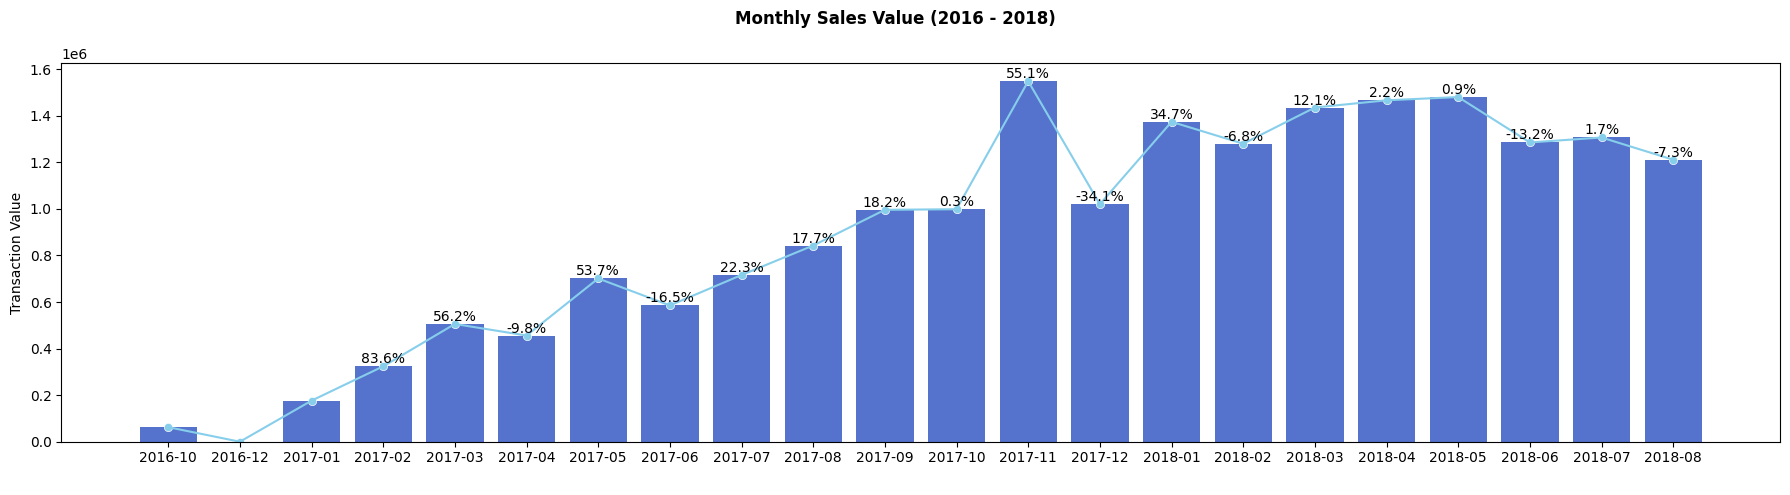

In [6]:
# groupby monthly sales
monthly_sales = transactions.groupby(by='month_year')['payment_value'].sum().to_frame().reset_index()

# add growth rate for each month column to the variable
monthly_sales['growth_rate'] = (monthly_sales['payment_value'].pct_change()*100).round(1)

# plot the data
plt.figure(figsize=(18,5))

plt.suptitle('Monthly Sales Value (2016 - 2018)', fontweight='bold')
sns.barplot(x='month_year', y='payment_value', data=monthly_sales, color='royalblue')
sns.lineplot(x='month_year', y='payment_value', data=monthly_sales, color='skyblue')
sns.scatterplot(x='month_year', y='payment_value', data=monthly_sales, color='skyblue')
plt.xlabel(' ')
plt.ylabel('Transaction Value')

# annotate the growth rate
for idx, row in monthly_sales.iterrows():
    if row['month_year'] > '2017-01':
        plt.text(row.name, row['payment_value'], f"{row['growth_rate']}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [7]:
# make tableau data
monthly_sales.to_csv('tableau_data/monthly_sales_projection.csv')

In [8]:
print(f'Average Monthly Growth: {monthly_sales[monthly_sales['month_year'] > '2017-01']['growth_rate'].mean().round(1)}%')

Average Monthly Growth: 14.3%


- The Olist's e-commerce platform has been doing great in terms of transaction value growth. Although the sales value each month often fluctuate, the overall performance are showing a positive trend for the past two years, with having an average monthly growth of **14.3%.** 
- There are a huge 55% leap during the month of November in 2017 that immedietly take a dive the next month, this anomaly are likely to be the affect of the **Black Friday** sales, an annual event where both online and offline shopping retailer offers a huge amount of discount to their products. [Ref](https://www.independent.co.uk/news/world/black-friday-2017-brazil-shoppers-discount-sales-brazil-south-africa-a8073651.html)

- However, along the way the pattern shows the implication of *The Law of Diminishing Returns* where after reaching its peak in November 2017, the sales growth remains constant and even experience a deacrese towards the end of the data. The company should review this going forward since the company should be able to generate constant positive growth to be sustainable in the future.   [Ref](https://www.techtarget.com/searchcustomerexperience/definition/law-of-diminishing-returns#:~:text=The%20law%20of%20diminishing%20returns%20is%20an%20economic%20principle%20stating,variables%20remain%20at%20a%20constant.)
- Although the monthly performance can represent the fraction of the company's growth it is better to understand the quarterly data to make strategic decisions and forecast assumptions. 

#### **Quarterly Performance**

Most businesses use quarterly performances as a benchmark to track progress, reviewing strategic decisions and forecasting financials target. It is the perfect time interval that is long enough to represent a certain strategic or policy results, but not too long to exclude the important seasonal details and allow early interventions. [Ref](https://www.frankli.io/post/7-reasons-to-move-to-quarterly-performance-reviews)

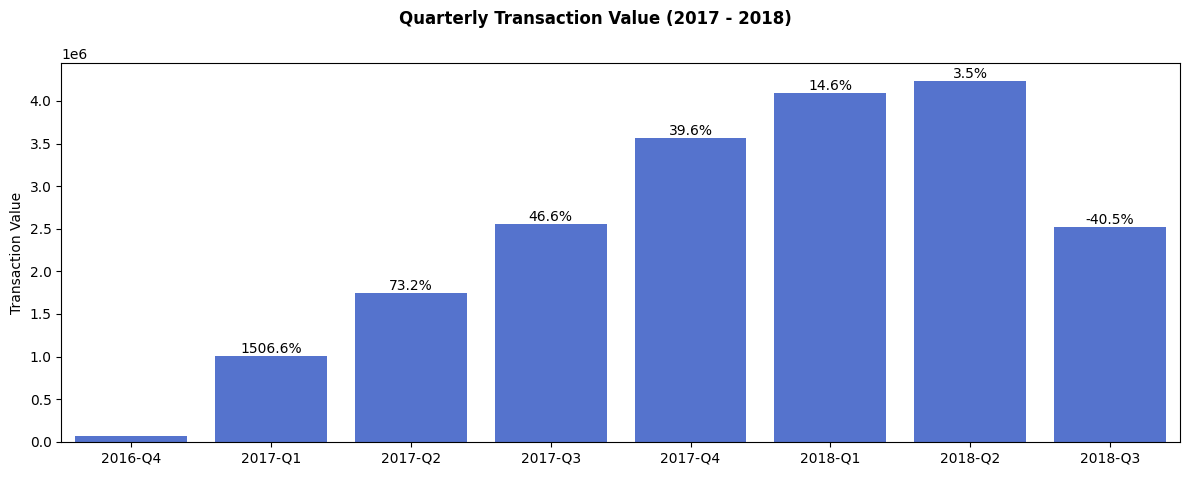

In [9]:
# Convert 'month_year' to datetime
quarterly_sales = transactions.copy()
quarterly_sales['month_year'] = pd.to_datetime(quarterly_sales['month_year'])


# Group by quarter and aggregate
quarterly_sales = quarterly_sales.groupby(quarterly_sales['month_year'].dt.to_period("Q")).sum('payment_value').reset_index()
quarterly_sales['growth_rate'] = (quarterly_sales['payment_value'].pct_change()*100).round(1)
quarterly_sales['month_year'] = quarterly_sales['month_year'].dt.strftime('%Y-Q%q')
quarterly_sales

plt.figure(figsize=(12,5))

plt.suptitle('Quarterly Transaction Value (2017 - 2018)', fontweight='bold')
sns.barplot(x='month_year', y='payment_value', data=quarterly_sales, color='royalblue')
plt.xlabel(' ')
plt.ylabel('Transaction Value')

for idx, row in quarterly_sales.iterrows():
    if pd.notna(row['growth_rate']):
        plt.text(row.name, row['payment_value'], f"{row['growth_rate']}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Although the monthly growth of the transactions shows fluctiations, the quarterly performance is shaping a consistent upward trends. 
- The *law of diminishing returns* is more visible in the quarterly period, as the chart above conclude that the growth rate are slowly decreasing from the Q2 of 2017.

- Considering that the timeframe of available transaction data only spans within the range of 2 years, rather than using the annual growth rate, quarterly data can be used to set realistic targets for forecasting. For this analysis, the method that are going to be used is the ***Compounding Growth Rate*** method, adjusted to quartely timeframe. This metric are going to be used to forecast the platform's sales projection in the next 4 quarters.[Ref](https://www.investopedia.com/investing/compound-annual-growth-rate-what-you-should-know/#:~:text=Compound%20annual%20growth%20rate%2C%20or,fall%20in%20value%20over%20time.)

In [10]:
# calculating olist's cagr
beginning_value = quarterly_sales.iloc[1]['payment_value']  # using the 2017-Q1 as beginning value (the 2016-Q4 data are incomplete and doesnt represent all month in Q4)
ending_value = quarterly_sales.iloc[-2]['payment_value']   # using the 2018-Q2 as ending value (the 2018-Q3 is not yet complete)

cagr = (((ending_value/beginning_value)**(1 / (len(quarterly_sales)))) - 1)*100
print(f'''Compounded Growth Rate =  {(cagr).round(1)}%''')

Compounded Growth Rate =  19.7%


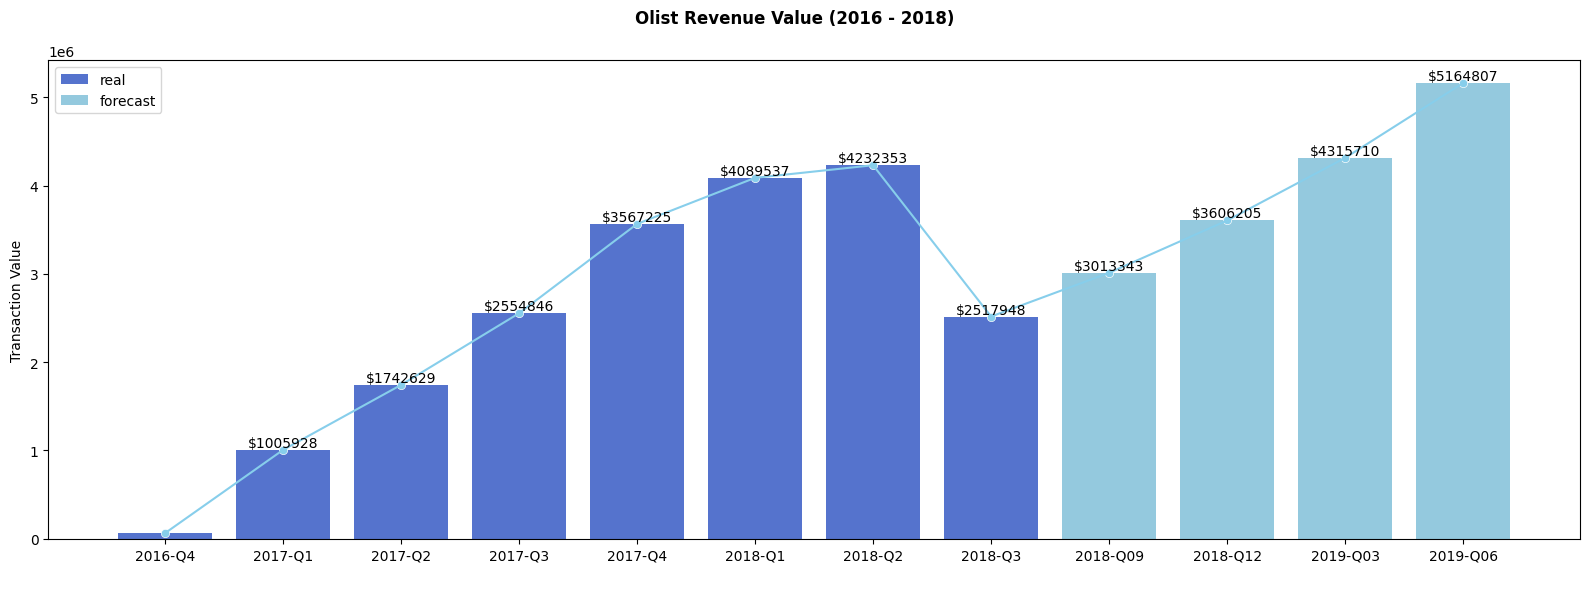

In [11]:
# forecast
quarterly_forecast = quarterly_sales.copy()
quarterly_forecast['status'] = 'real'

forecast_values = []
for i in range(1, 5):
    forecast_values.append(quarterly_forecast['payment_value'].iloc[-1]  * (1 + (cagr/100))**i)

forecast_data = pd.DataFrame({'month_year': pd.date_range(start=monthly_sales['month_year'].iloc[-1], periods=4, freq='Q').strftime('%Y-Q%m'),
                              'payment_value': forecast_values,'growth_rate': [cagr.round(1)] * 4,'status': ['forecast']*4})
quarterly_forecast = pd.concat([quarterly_forecast,forecast_data]).reset_index(drop=True)

plt.figure(figsize=(16,6))

plt.suptitle('Olist Revenue Value (2016 - 2018)', fontweight='bold')
sns.lineplot(x='month_year', y='payment_value', data=quarterly_forecast, color='skyblue')
sns.barplot(x='month_year', y='payment_value', data=quarterly_forecast, hue='status', palette=['royalblue','skyblue'])
sns.scatterplot(x='month_year', y='payment_value', data=quarterly_forecast, color='skyblue')
plt.xlabel(' ')
plt.ylabel('Transaction Value')

for idx, row in quarterly_forecast.iterrows():
    if pd.notna(row['growth_rate']):
        # plt.text(row.name, row['payment_value'], f"{row['growth_rate']}%", ha='center', va='bottom', fontsize=8)
        plt.text(row.name, row['payment_value'], f"${row['payment_value']:.0f}", ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

- With the assumptions that the company are targeted to have exponential growth at 19%, Olist is projected to have a total transaction value of 5.164.807 R$ by the Q2 of 2019.
- This data can be the KPI target in formulating future sales strategy.

> **Note:** These projections are based on hypothetical assumptions from the historical performance, meaning that there are many external factor that might have an affect in the real case. If Olist is keen on realizing this projection they need to ensure that the future performance can be as good or better then the ones thay already achieves. 


### **Product Sales Analysis**


In [12]:
products = transactions.copy()

In [13]:
cat_products = products.groupby('product_category_name')['payment_value'].sum().sort_values(ascending=False).to_frame().reset_index()
cat_products['percentage'] = (cat_products['payment_value'] / cat_products['payment_value'].sum())

cat_products_value = products.groupby('product_category_name')['order_id'].count().sort_values(ascending=False).to_frame().reset_index()
cat_products_value['percentage'] = (cat_products_value['order_id'] / cat_products_value['order_id'].sum())

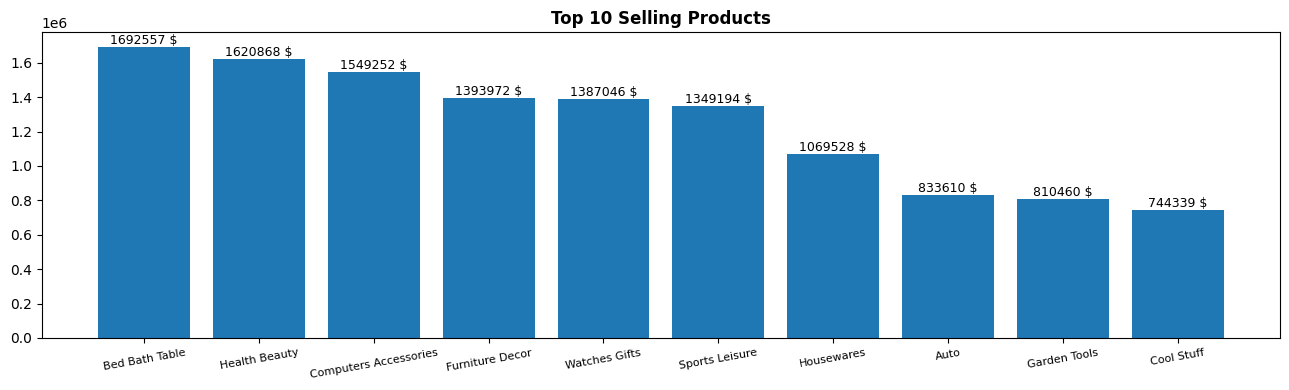

In [14]:
top_10_selling = cat_products.head(10)

plt.figure(figsize=(13,4))

plt.title('Top 10 Selling Products', fontweight='bold')
bars = plt.bar(data=top_10_selling, x='product_category_name', height='payment_value')
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y, f'{int(y)} $', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=10, fontsize=8)    
plt.tight_layout()
plt.show()

### **The Black Friday Anomaly**

In earlier analysis it is concluded that the sales spike during the month of November in 2017 are likely due to the effect of **Black Friday** an annual retail shopping trend where products are offered with huge discounts in the day after *thanksgiving*. We are going to analyze further this statement by looking at the daily sales time series.
[Ref](https://www.pagbrasil.com/insights/black-friday-in-brazil-everything-you-need-to-know/)

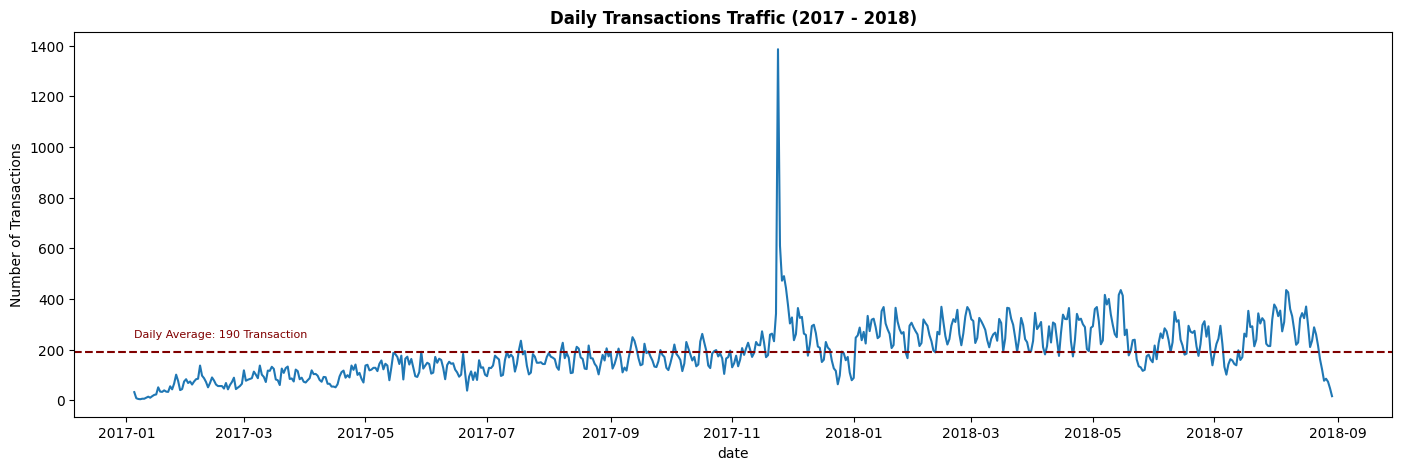

In [15]:
daily_traffic = transactions[transactions['month_year'] > '2016-12']
daily_traffic = daily_traffic.groupby(by='date')['order_id'].count().to_frame().reset_index()
daily_average = daily_traffic['order_id'].mean()

plt.figure(figsize=(17,5))
plt.title('Daily Transactions Traffic (2017 - 2018)', fontweight='bold')
plt.ylabel('Number of Transactions')
sns.lineplot(x='date', y='order_id', data=daily_traffic)

plt.axhline(y=daily_average, color='maroon', linestyle='--', label='Average Daily Sales')
plt.text(x=daily_traffic['date'].iloc[0], y=250, s=f'Daily Average: {int(daily_average)} Transaction', fontsize=8, color='maroon')

plt.show()

In [16]:
daily_traffic[daily_traffic['order_id']> 800]

,date,order_id
323,2017-11-24,1386


- It is confirmed that the sales spike, in fact does occurs in the day after thanksgiving at 24th November, where **Black Friday** is annualy celebrated. In this day the platfrom are able to execute **1.386 transactions** in one day, which is 730% the average daily transactions. [Ref](https://www.calendardate.com/thanksgiving_2017.htm)

Since the Black Friday is an **annual trends**, the company can use the transaction data to find insights and pattern in the customer's behavior towards to prepare strategic decisions in this trend going forward. 

In [17]:
# making a variable of all the transactions happening in the black friday
black_friday = transactions.copy()
black_friday['date'] = transactions['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
black_friday = black_friday[black_friday['date'] ==	'2017-11-24']

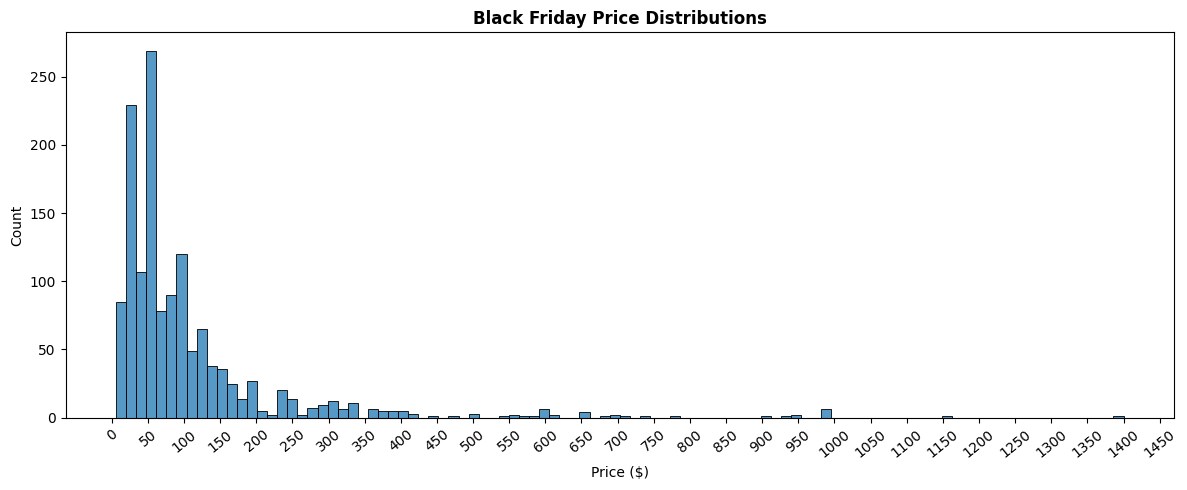

In [18]:
plt.figure(figsize=(12,5))

plt.title('Black Friday Price Distributions',fontweight='bold')
sns.histplot(black_friday[black_friday['price']<1500]['price'], bins=100) # limit the price to make the visual more readable
plt.xticks(range(0, 1451, 50), rotation=39)
plt.xlabel('Price ($)')

plt.tight_layout()
plt.show()

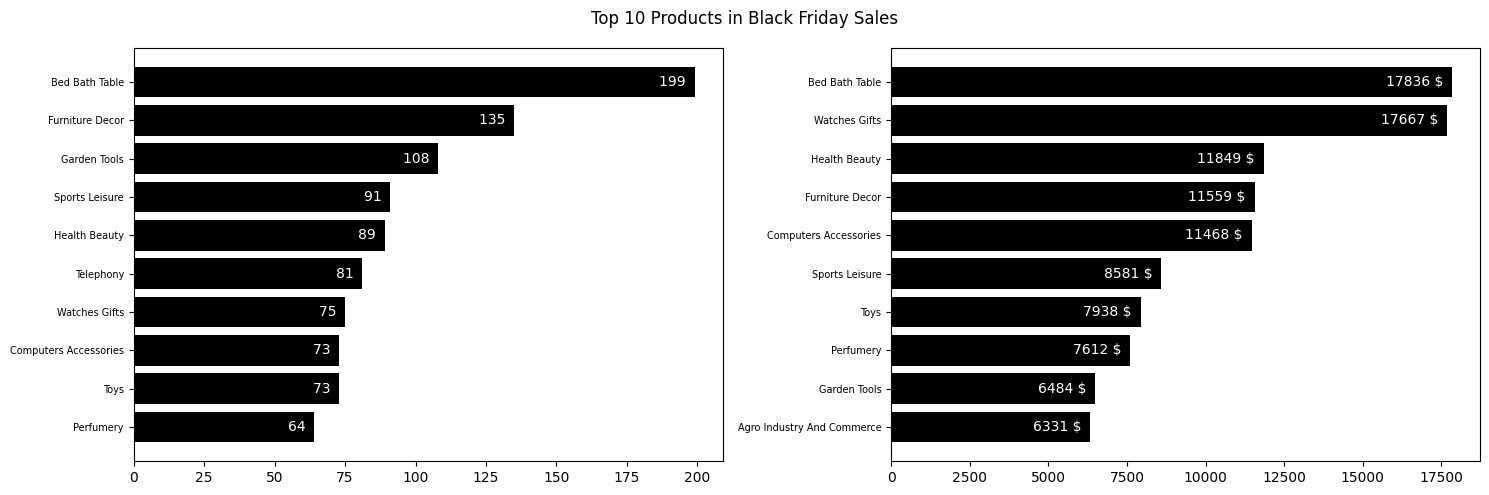

In [19]:
top_products = black_friday.groupby('product_category_name')['order_id'].count().sort_values(ascending=False).head(10).to_frame().reset_index()
top_products_value = black_friday.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(10).to_frame().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Top 10 Products in Black Friday Sales')

bars1 = axs[0].barh(top_products['product_category_name'][::-1], width=top_products['order_id'][::-1], color='black')
bars2 = axs[1].barh(top_products_value['product_category_name'][::-1], width=top_products_value['price'][::-1], color='black')

axs[0].set_yticklabels(labels=top_products['product_category_name'][::-1], fontsize=7)
axs[1].set_yticklabels(labels=top_products_value['product_category_name'][::-1], fontsize=7)

for bar in bars1:
    y = bar.get_width()
    axs[0].text(y, bar.get_y() + bar.get_height()/2, f'{int(y)}  ', ha='right', va='center', fontsize=10, color='white')

for bar in bars2:
    y = bar.get_width() 
    axs[1].text(y, (bar.get_y() + bar.get_height()/2), f'{int(y)} $  ', ha='right', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()


- The top 10 products shows that in **Black Friday** the products that have highest demands are **secondary to tertiary** products. This shows that the customer pattern in Black Friday is not a fulfilling primary needs rather is a place where the customer could get a cheaper price on these secondary and tertiary products. [Ref](https://www.bfi.co.id/en/blog/kebutuhan-primer-dan-kebutuhan-lainnya)

### **Customer Location Analysis**


#### **Top 10 States with Most Number of Active Customers**

In [20]:
customers = transactions.drop_duplicates(subset=['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
'customer_city', 'customer_state'])

In [21]:
top10state = customers.groupby(by='customer_state').count()['customer_id'].sort_values(ascending=False).head(10).to_frame()
top10state['%'] = (top10state['customer_id'] / len(customers))
top10state['%'] = top10state['%'].round(2)

top10city = customers.groupby(by='customer_city').count()['customer_id'].sort_values(ascending=False).head(10).to_frame()
top10city['%'] = (top10city['customer_id'] / len(customers))
top10city['%'] = top10city['%'].round(2)

display(
top10city,
top10state)

,customer_id,%
customer_city,,
Sao Paulo,15043,0.16
Rio De Janeiro,6603,0.07
Belo Horizonte,2697,0.03
Brasilia,2075,0.02
Curitiba,1489,0.02
Campinas,1406,0.01
Porto Alegre,1341,0.01
Salvador,1188,0.01
Guarulhos,1143,0.01


,customer_id,%
customer_state,,
SP,40487,0.42
RJ,12351,0.13
MG,11352,0.12
RS,5342,0.06
PR,4923,0.05
SC,3547,0.04
BA,3255,0.03
DF,2080,0.02
ES,1995,0.02


- **SP** (Sao Paolo) is the state with most number of Olist customers, with **40.487** customer which is **42%** of all customers are from the state. 
- **RJ** (Rio de Janeiro) and **MG** (Minas Garais) came in second and third with a small margins with 13% and 12%, but a huge gap from the market leader (SP).
- Beside the top four, the market share in the other states are not surpassing the **5%** mark.

- **Sao Paolo** becomes the city with most number of Olist customers, with 15.540 customer which is **16%** of all customers are from the city. 
- **Rio de Janeiro** came in second in a relatively huge gap with **6.882** customer, consisting of **7%** of all customers.
- Beside the top 5, the number of customer of the other cities are all below 1% market share.

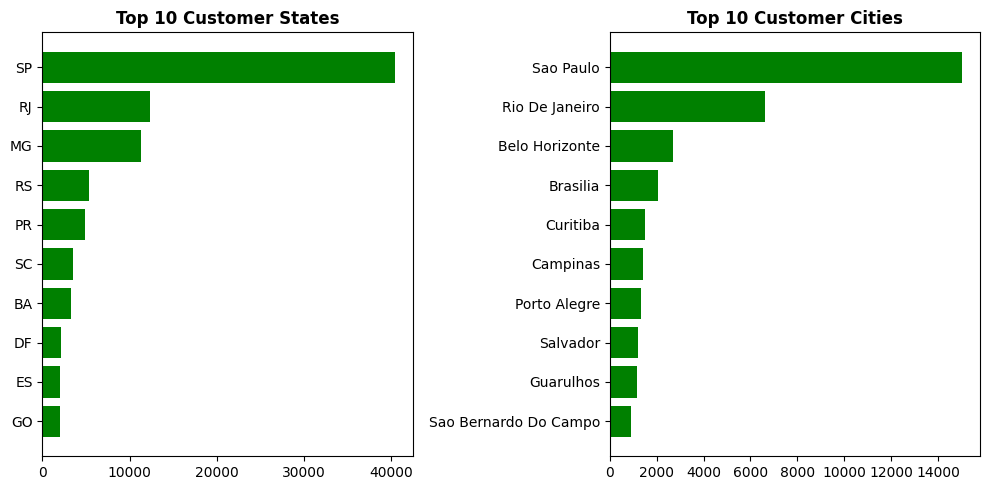

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].set_title('Top 10 Customer States', fontweight='bold')
axs[0].barh(top10state.iloc[::-1].index, width=top10state['customer_id'][::-1], color='g')

axs[1].set_title('Top 10 Customer Cities', fontweight='bold')
axs[1].barh(top10city.iloc[::-1].index,width=top10city['customer_id'][::-1], color='g')

plt.tight_layout()
plt.show()

**Main Takeaways**

- The market is still very saturated towards one states: **Sao Paolo**, this means that the company still has a lot of market to expand their services. As the market penetration rate for e-commerce in Brazil is increasing, Olist need to use this momentum to grab as much market share as possible. [Ref](https://www.statista.com/forecasts/252404/digital-buyer-penetration-in-brazil)

- It is important for the company to do execute thorough research and filtering about the investment allocation towards a certain location. Reading the demographic and customer behavior to make the right decision of expansions.

### **Customer Reviews Analysis**
--- 
Customer reviews are a vital part of an e-commerce platforms, since it is one way the company can interact with the customers. Resonates with their complaint and improve the platform's services and seller filtering.

#### **Order Review Summary**

In [25]:
order_reviews = df.drop_duplicates(subset=['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 
                    'review_creation_date', 'review_answer_timestamp'])

# turn the data into floats
order_reviews['review_score'] = pd.to_numeric(order_reviews['review_score'], errors='coerce')

In [26]:
order_reviews['status'] = np.where(order_reviews['review_score'] >= 3, 'positive','negative')
order_reviews.groupby(by='status').count()['order_id']

status
negative    12916
positive    83542
Name: order_id, dtype: int64

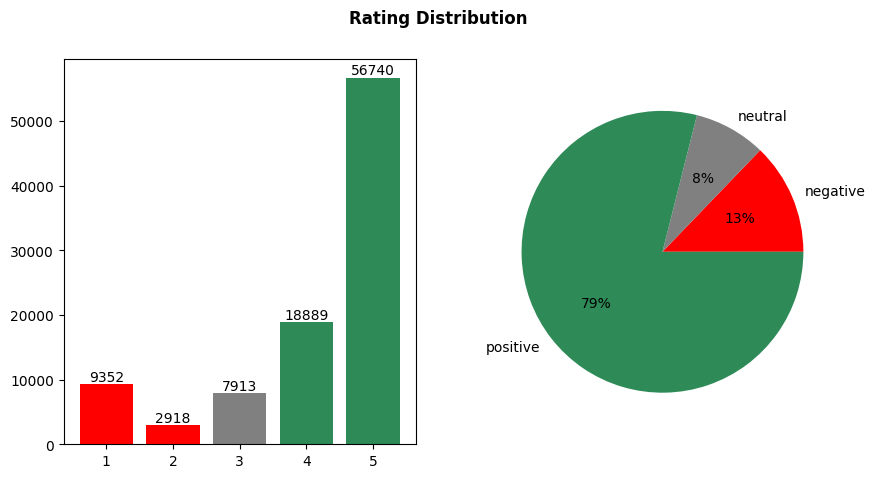

In [27]:
score_summary = order_reviews.groupby(by='review_score').count()['review_id'].to_frame()
score_summary['status'] = np.where(score_summary.index == 3, 'neutral',
                         (np.where(score_summary.index > 3,'positive','negative')))

fig, axs = plt.subplots(1,2,figsize=(10,5))

plt.suptitle('Rating Distribution', fontweight='bold')
bars = axs[0].bar(x=score_summary.index,height=score_summary['review_id'], color=['red','red','grey','seagreen','seagreen'])
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
axs[1].pie(score_summary.groupby(by='status').sum()['review_id'], autopct='%.0f%%', colors=['red','grey','seagreen'], labels=score_summary['status'].unique())

plt.show()

- The aggregations of the ratings show that most customers give a positive experience from most transactions, given that the positive review (4 and 5) takes up about **79% of the data** with the 5 star reviews takes up most of the overall data.


In [28]:
status_product = order_reviews.groupby(by=['status', 'product_category_name']).count()['order_id'].to_frame().reset_index()
status_product = status_product.groupby(by=['product_category_name','status']).sum()['order_id'].to_frame().reset_index()

# After observation, there are two lost row because it has 0 negative review
status_product.loc[len(status_product.index)] = ['Cds Dvds Musicals', 'negative', 0]  
status_product.loc[len(status_product.index)] = ['Fashion Childrens Clothes', 'negative', 0]  

In [29]:
name = []
positive = []
negative = []

for row in range(len(status_product)):
    product_name = status_product.loc[row, 'product_category_name']

    if product_name not in name:
        name.append(product_name)

    if status_product.loc[row, 'status'] == 'positive':
        positive.append(status_product.loc[row, 'order_id'])
        
    elif status_product.loc[row, 'status'] == 'negative':
        negative.append(status_product.loc[row, 'order_id'])

review_ratio = pd.DataFrame({'Product':name, 'positive':positive,'negative':negative})
review_ratio = review_ratio[review_ratio['Product'] != 'Unknown'] # remove the unknowns

review_ratio['positive ratio'] = (review_ratio['positive'] / (review_ratio['negative'] + review_ratio['positive'])*100).round(2)
review_ratio['negative ratio'] = (review_ratio['negative'] / (review_ratio['positive'] + review_ratio['negative'])*100).round(2)

top_positive = review_ratio.sort_values(by='positive ratio', ascending=False).head(10).reset_index(drop=True)[['Product','positive','positive ratio']]
top_negative = review_ratio.sort_values(by='negative ratio', ascending=False).head(10).reset_index(drop=True)[['Product','negative','negative ratio']]

display(top_positive, top_negative)

,Product,positive,positive ratio
0,Watches Gifts,4696,100.00
1,Perfumery,2708,99.96
2,Housewares,5002,99.94
3,Office Furniture,964,99.90
4,Cool Stuff,3114,99.90
5,Furniture Decor,5240,99.87
6,Sports Leisure,6609,99.83
7,Luggage Accessories,925,99.68
8,Fashion Bags Accessories,1620,99.63
9,Health Beauty,7598,99.04


,Product,negative,negative ratio
0,Security And Services,73,98.65
1,Pc Gamer,183,97.34
2,Furniture Mattress And Upholstery,1010,97.12
3,Party Supplies,367,91.98
4,Music,282,89.24
5,Dvds Blu Ray,344,87.76
6,Tablets Printing Image,454,87.31
7,Computers,971,86.31
8,Construction Tools Tools,413,82.77
9,Food Drink,969,82.26


- We can see in this insights that most of the product that has a high `negative` and `positive` ratios are sensitive products that has a high elasticity of satisfaction.
- This information can be used to improve the service system and product going forward.

#### **Correlating Review Results with the Order Time Metrics**

For this analysis, we are going to create several metrics to represents the order time performance. 

- `purchase to approval`  : the intervals from the time the order was purchased by the buyer until the time the order was approved by the seller. For different distribution visualization, this variable will be represented by days and seconds.
- `approval to delivered` : the intervals from the time the order was approved by the buyer until the time the order was delivered to the buyer. This variable will be represented in days.
- `purchase to delivered` : the intervals from the time the order was purchased until the time the order was delivered to the buyer. This variable will be represented in days.
- `estimation accuracy`   : the accuracy of estimation time, the difference between the estimated time and real time the product was delivered. This variable will be represented in days.


In [30]:
order_reviews['review_score'] = pd.to_numeric(order_reviews['review_score'], errors='coerce')

to_dt = [ 'order_estimated_delivery_date','order_approved_at','order_delivered_customer_date','order_purchase_timestamp']

for col in to_dt:
    order_reviews[col] = pd.to_datetime(order_reviews[col])

# making the metrics
order_reviews['purchase to approval (seconds)'] =  (order_reviews['order_approved_at'] - order_reviews['order_purchase_timestamp']).dt.seconds
order_reviews['purchase to approval (days)'] =  (order_reviews['order_approved_at'] - order_reviews['order_purchase_timestamp']).dt.days
order_reviews['approval to delivered'] =  (order_reviews['order_delivered_customer_date'] - order_reviews['order_approved_at']).dt.days
order_reviews['purchase to delivered'] =  (order_reviews['order_delivered_customer_date'] - order_reviews['order_purchase_timestamp']).dt.days
order_reviews['estimation accuracy'] =  (order_reviews['order_delivered_customer_date'] - order_reviews['order_estimated_delivery_date']).dt.days

order_reviews = order_reviews[['review_score','purchase to approval (seconds)', 'approval to delivered','purchase to delivered', 'estimation accuracy']]
order_reviews = order_reviews[order_reviews['review_score'] != 'unknown']

In [31]:
order_reviews.corr(method='pearson', numeric_only=True)['review_score'].to_frame()

,review_score
review_score,1.000000
purchase to approval (seconds),-0.006881
approval to delivered,-0.333359
purchase to delivered,-0.333739
estimation accuracy,-0.266558


- The correlation calculation shows that although not significant, there are negative correlation ranging from **-26% to -33%**, bit the time of approval has little correlation. 
- This means that in some review, the speed of the shipment are likely to affects the review score. But the approval process doesn't affect the review very much.

### **Customer Behavior Analysis**
--- 
Understanding the pattern of how customers interact with a platform can empower strategic decisions with personalizing experiences and creating a more targeted marketing.

#### **Customers Payments Approach**

In [65]:
types_payment = transactions.groupby(by='payment_type').count()['order_id'].sort_values(ascending=False).to_frame()
types_payment

,order_id
payment_type,
Credit Card,84892
Boleto,22347
Voucher,6123
Debit Card,1653


- In the brazillian e-comemrce ecosystem, there four main method of payments : **Credit Card, Boleto, Voucher, and Debit Card**.

- Credit cards offer convenience and deferred payment, while Boleto is a popular cash-based option. Vouchers provide discounts or credits, and Debit Cards enable direct fund deductions, catering to a range of user preferences. [Ref](https://www.rapyd.net/blog/what-is-boleto/)

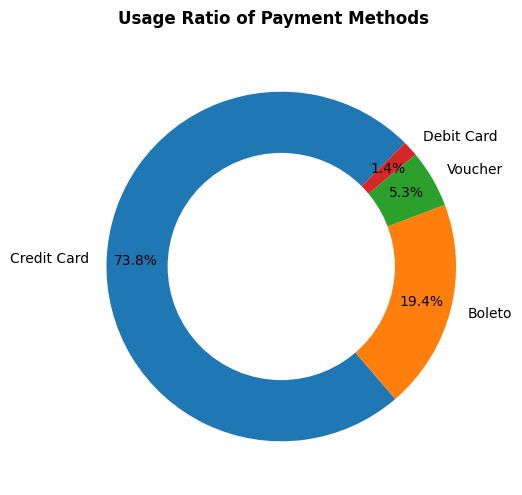

In [101]:
plt.figure(figsize=(6, 5))
plt.suptitle('Usage Ratio of Payment Methods', fontweight='bold')

plt.pie(types_payment['order_id'], labels=types_payment.index, autopct='%1.1f%%', startangle=45,
                                   pctdistance=0.83)

centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()

- The data underscores a clear trend with a majority of buyers opting for the convenience of **Credit cards** with a staggering **73.8%** of the transcactions are using credit cards, followed by Boleto users which has a comparatively smaller segment. 
- This insight indicates a strong reliance for credit card among customers.  the platform has an opportunity to introduce benefits, incentives, or exclusive offers that resonate with these credit card users.

- By enhancing the credit card experience, the platform can not only retain existing users but also attract a fresh new audience, hence leading to sustainability and improvements of customer satisfaction.

#### **Customers Transaction Time**

<Axes: xlabel='hour', ylabel='day-dayname'>

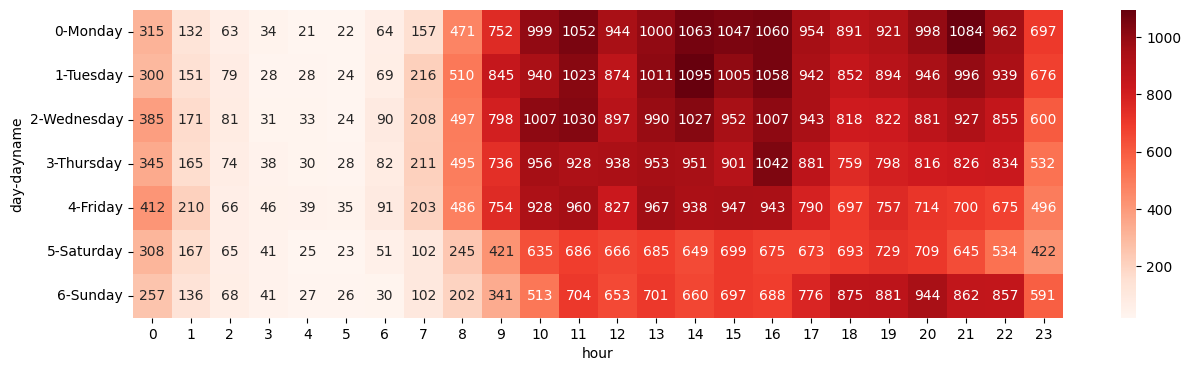

In [32]:
cust = transactions.drop_duplicates(subset='order_id')
cust_time = cust.groupby(by=['hour','day','dayname']).count()['order_id'].to_frame().reset_index()
heatmap_cust = cust_time.pivot_table(values='order_id', index=['day','dayname'],columns='hour')
heatmap_cust
plt.figure(figsize=(15,4))
sns.heatmap(heatmap_cust, annot=True, fmt='g', cmap='Reds')

- The heatmap above shows the transaction traffic in each hour of every day of the week, the map shows a density of purchases occurs in the weekdays, from 8 AM all the way until midnight. 

#### **Recurring Customers**

In [33]:
repurchase = transactions.drop_duplicates(subset='order_id')
repurchase = repurchase.groupby(by='customer_unique_id')['order_id'].count().reset_index().sort_values(by='order_id',ascending=False)
repurchase['order_class'] = np.where(repurchase['order_id'] == 1, '1',
                                     np.where((repurchase['order_id'] > 1) & (repurchase['order_id'] <= 3), '2-3',
                                              np.where((repurchase['order_id'] >3) & (repurchase['order_id'] <= 9), '4-9', '>10')))
repurchase.head(5)

,customer_unique_id,order_id,order_class
51423,8d50f5eadf50201ccdcedfb9e2ac8455,15,>10
22775,3e43e6105506432c953e165fb2acf44c,9,4-9
36702,6469f99c1f9dfae7733b25662e7f1782,7,4-9
73907,ca77025e7201e3b30c44b472ff346268,7,4-9
10058,1b6c7548a2a1f9037c1fd3ddfed95f33,7,4-9


In [34]:
top_class = repurchase.groupby('order_class')['order_id'].sum().to_frame()
top_class['%'] = top_class['order_id']/top_class['order_id'].sum()
top_class

,order_id,%
order_class,,
1,90539,0.938637
2-3,5687,0.058958
4-9,217,0.002250
>10,15,0.000156


- After classifying the number of order made by the customer, there is a huge imbalance between the one-time buyer and the recurring buyer, with the majority of customers **(93%)** being a one-time buyer. **With only 15 people are recurring customers** with more than 10 purchases in 2 years.
- Olist have been doing a great job in acquiring customers, but the company need to innovate in strategy to maintain the customers to engage in their platform.

#### **Cohort Retention Rate**

ohort retention rate is a metric that measures the proportion of customers who continue to do business with a company over a certain period. Company can use this metric to asses engagement and loyalty of the customer. [Ref](https://www.omniconvert.com/what-is/cohort-retention-rate-customer-stickiness/#:~:text=Cohort%20retention%20rate%20is%20a,they%20made%20their%20first%20purchase.)

In [35]:
cohort = transactions.copy()
cohort = cohort.drop_duplicates(subset='order_id', keep='first')[['customer_unique_id', 'month_year']]
cohort['initial_order'] = cohort.groupby('customer_unique_id')['month_year'].transform('min')

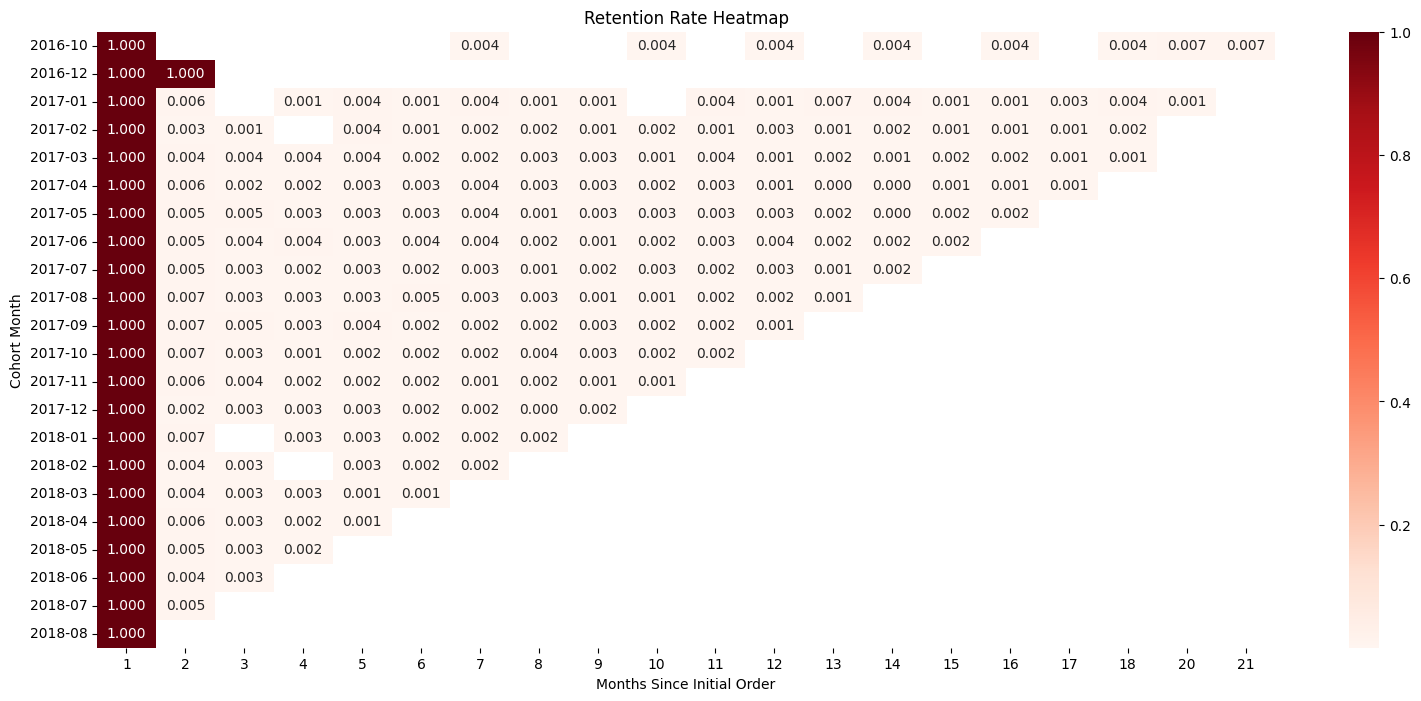

In [36]:
cohort['month_year'] = pd.to_datetime(cohort['month_year'], format='%Y-%m')
cohort['initial_order'] = pd.to_datetime(cohort['initial_order'], format='%Y-%m')

cohort['initial_month'] = cohort['initial_order'].dt.to_period("M")
cohort['cohort_index'] = (cohort['month_year'] - cohort['initial_order']).dt.days // 30 + 1

retention_pivot = cohort.pivot_table(index='initial_month', columns='cohort_index', values='customer_unique_id', aggfunc='nunique')
retention_rates = retention_pivot.divide(retention_pivot.iloc[:, 0], axis=0)

# Plot the heatmap
plt.figure(figsize=(19, 8))
sns.heatmap(retention_rates, annot=True, fmt='.3f', cmap='Reds')
plt.title('Retention Rate Heatmap')
plt.xlabel('Months Since Initial Order')
plt.ylabel('Cohort Month')
plt.show()

- The graph shows that the overall **consumer retention rate is very low**, new users making subsequent transactions in the following months are not surpassing 1%, indicating that only a small fraction of users make repeat purchases.
- A low retention rate may lead to a decrease in the average revenue generated from each customer over their lifetime with the business. This can impact the overall sustainability of the company.
- This could have a domino effect in in which the sellers are not getting enough buyers from this and refer to other e-commerce platform. Low retention rates can limit the effectiveness of word-of-mouth marketing and referral programs.
- The company should really take this into considerations, since the market are becoming more and more competitive, they should really invest more in recurring customer acquisitions. 